In [15]:
from z3 import *
import z3
import pandas as pd
import time
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from itertools import islice
from functools import reduce
from typing import List

In [16]:
def parse_queries_from_klee_smt2_dump(path: str):
    queries = []
    with open(path) as f:
        current = ""
        for line in f:
            if line == "(check-sat)":
                continue
            if line.strip() == "(reset)":
                queries.append(z3.parse_smt2_string(current))
                current = ""
            current += line
    return queries

In [17]:
queries = parse_queries_from_klee_smt2_dump("sort-cache-notimelimit.smt2")
# queries = parse_queries_from_klee_smt2_dump("who-cache.smt2")
print(f"{len(queries)} queries were loaded.")

KeyboardInterrupt: 

In [ ]:
def calc_distance_keeping_constraint_order(first: list, second: list, pop_cost, push_cost):
    """
    Calculates a distance between two queries while not trying to change the order
    of constraints inside them.
    The returned distance mimics the cost of pushing and popping when the second query
    is solved right after the first query.
    """
    i = 0
    while i < len(first) and i < len(second) and first[i].eq(second[i]):
        i += 1

    return (i, pop_cost(len(first) - i) + push_cost(len(second) - i))
    # If you believe that there's no cost in popping, you can use the following
    # formula. But personally, I see each pop as a negative thing and losing a
    # progress.
    # return (i, len(second) - i)

def calc_distances_for(query_index: int, queries, calc_distance, pop_cost, push_cost):
    query = queries[query_index]
    distances = [0] * len(queries)
    for j in range(len(queries)):
        distances[j] = calc_distance(query, queries[j], pop_cost, push_cost)
    return distances

pop_cost = lambda x: x
push_cost = lambda x: x

def calc_distances_for_map(query_index: int):
    return calc_distances_for(query_index, queries, calc_distance_keeping_constraint_order, pop_cost, push_cost)

In [ ]:
with ProcessPoolExecutor() as executor:
    distances = list(tqdm(executor.map(calc_distances_for_map, range(len(queries))), total=len(queries)))

common_prefix_lens = [[col[0] for col in row] for row in distances]
distances = [[col[1] for col in row] for row in distances]

100%|██████████| 4330/4330 [00:53<00:00, 81.44it/s] 


In [ ]:
common_prefix_lens = pd.Series([pd.Series(cpl) for cpl in common_prefix_lens])

In [33]:
def check_by_resetting(queries, ordering, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}
    
    total_time = 0.0
    
    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        query = queries[index]
        start_time = time.perf_counter()
        result = solver.check(query)
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result
    
    return results, total_time
    

def check_mixed_incrementally(queries, ordering, cpl, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}
    
    total_time = 0.0
    
    # assert len(set([str(q[:cpl]) for q in [queries[qi] for qi in ordering]])) == 1
    solver.add(queries[ordering[0]][:cpl])
    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        query = queries[index]
        start_time = time.perf_counter()
        solver.push()
        solver.add(query[cpl:])
        result = solver.check()
        solver.pop()
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result
    
    return results, total_time

def check_dummy_incrementally(queries, ordering: List[int], solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}

    last_query = []

    total_time = 0.0
    total_pops = 0
    total_pushes = 0

    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        if index in results:
            print("Warning: Skipping repeated query. Query index =", index)
            continue
        query = queries[index]
        
        i = 0
        while i < len(last_query) and i < len(query) and last_query[i].eq(query[i]):
            i += 1

        start_time = time.perf_counter()
        
        solver.pop(len(last_query) - i)
        total_pops += len(last_query) - i

        for i in range(i, len(query)):
            solver.push()
            total_pushes += 1
            solver.add(query[i])
        
        result = solver.check()
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result

        last_query = query
    
    return (results, total_time, (total_pushes, total_pops, sum(len(q) for q in queries)))

def check_incrementally(queries, ordering: List[int], common_prefix_lens, enable_direct_subset_answer=False, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}

    queries = queries + [queries[ordering[-1]]]
    ordering = ordering + [ordering[-1]]
    
    last_index = len(queries) - 1
    current_stack_count = 0

    total_time = 0.0
    total_pops = 0
    total_pushes = 0

    ordering_iter = zip(ordering[:len(ordering) - 1], ordering[1:])
    if enable_tqdm:
        ordering_iter = tqdm(ordering_iter, total=len(ordering) - 1)
    for index, next_index in ordering_iter:
        if index in results:
            print("Warning: Skipping repeated query. Query index =", index)
            continue
        # last_query = queries[last_index]
        query = queries[index]
        
        next_prefix_len = common_prefix_lens[index][next_index]

        start_time = time.perf_counter()
        if enable_direct_subset_answer and current_stack_count == len(query) and results[last_index] == sat:
            results[index] = sat
        else:
            if current_stack_count < next_prefix_len:
                for i in range(current_stack_count, next_prefix_len):
                    solver.push()
                    solver.add(query[i])
                total_pushes += next_prefix_len - current_stack_count
                current_stack_count = next_prefix_len

            solver.push()
            total_pushes += 1
            solver.add(query[current_stack_count:])
            
            result = solver.check()

            solver.pop()
            total_pops +=1
                        
            results[index] = result
        
        if current_stack_count > next_prefix_len:
            solver.pop(current_stack_count - next_prefix_len)
            total_pops += current_stack_count - next_prefix_len
            current_stack_count = next_prefix_len

        end_time = time.perf_counter()
        total_time += end_time - start_time
        last_index = index
    
    return (results, total_time, (total_pushes, total_pops, sum(len(q) for q in queries)))

def benchmark(f, repeat=30):
    times = list()
    for i in tqdm(range(repeat)):
        spent_time = f()[1]
        times.append(spent_time)
    return times

266     418
260     384
2       379
267     281
265     267
       ... 
289       1
288       1
287       1
1891      1
283       1
Length: 131, dtype: int64

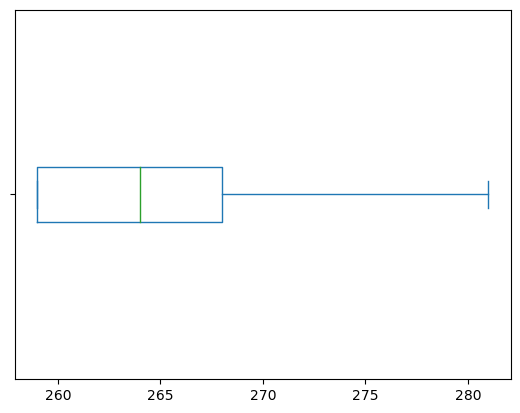

In [ ]:
query_lens = pd.Series(len(q) for q in queries)
query_lens.plot.box(vert=False, showfliers=False)
# query_lens[query_lens < 270][query_lens > 230].hist()
query_lens.value_counts()

In [ ]:
target_queries = pd.DataFrame(query_lens[query_lens > 220], columns=["Length"])
target_queries["CPL"] = common_prefix_lens[target_queries.index]
target_queries["CPLR"] = target_queries["CPL"] / target_queries["Length"]
target_queries["CPL_0"] = target_queries["CPLR"].map(lambda rs: (rs > 0.01).sum())
target_queries["CPL_0.01"] = target_queries["CPLR"].map(lambda rs: (0.1 >= rs[rs > 0.01]).sum())
target_queries["CPL_0.1"] = target_queries["CPLR"].map(lambda rs: (0.2 >= rs[rs > 0.1]).sum())
target_queries["CPL_0.2"] = target_queries["CPLR"].map(lambda rs: (0.5 >= rs[rs > 0.2]).sum())
target_queries["CPL_0.5"] = target_queries["CPLR"].map(lambda rs: (0.8 >= rs[rs > 0.5]).sum())
target_queries

,Length,CPL,CPLR,CPL_0,CPL_0.01,CPL_0.1,CPL_0.2,CPL_0.5
43,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0
44,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0
45,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0
46,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0
48,260,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,10,6,0,0,0
...,...,...,...,...,...,...,...,...
4325,1641,0 0 1 0 2 0 3 ...,0 0.000000 1 0.000000 2 0.00...,78,75,0,0,0
4326,1641,0 0 1 0 2 0 3 ...,0 0.000000 1 0.000000 2 0.00...,78,75,0,0,0
4327,1642,0 0 1 0 2 0 3 ...,0 0.000000 1 0.000000 2 0.00...,78,75,0,0,0
4328,1642,0 0 1 0 2 0 3 ...,0 0.000000 1 0.000000 2 0.00...,78,75,0,0,0


In [42]:
target_queries = pd.DataFrame(query_lens[query_lens > 220], columns=["Length"])
target_queries["CPL"] = common_prefix_lens[target_queries.index]
target_queries["CPL_30"] = target_queries["CPL"].map(lambda ls: (ls > 30).sum())
target_queries = target_queries[target_queries["CPL_30"] > 25]

print(target_queries.groupby("CPL_30").std(numeric_only=True))

target_queries = target_queries[target_queries["CPL_30"] == 53]
# assert len(set([str(q[:53]) for q in [queries[qi] for qi in target_queries.index]])) == 1
# target_subset = target_queries.iloc[0]["CPL"]
# target_subset = target_subset[target_subset > 30]
# target_queries.loc[target_subset.index]

target_queries


           Length
CPL_30           
26       0.000000
27       1.009390
29       9.619100
36       3.501020
53      90.349426
82       0.000000


,Length,CPL,CPL_30
3641,269,0 0 1 0 2 0 3 0 4 ...,53
3642,269,0 0 1 0 2 0 3 0 4 ...,53
3643,269,0 0 1 0 2 0 3 0 4 ...,53
3644,269,0 0 1 0 2 0 3 0 4 ...,53
3645,269,0 0 1 0 2 0 3 0 4 ...,53
3646,269,0 0 1 0 2 0 3 0 4 ...,53
3647,269,0 0 1 0 2 0 3 0 4 ...,53
3648,269,0 0 1 0 2 0 3 0 4 ...,53
3649,269,0 0 1 0 2 0 3 0 4 ...,53
3656,269,0 0 1 0 2 0 3 0 4 ...,53


In [47]:
cpl = common_prefix_lens[4125][4139]
cpl

268

In [44]:
result_res = check_by_resetting(queries, list(target_queries.index), enable_tqdm=True)[0]
result_mincr = check_mixed_incrementally(queries, list(target_queries.index), cpl, enable_tqdm=True)[0]
result_dincr = check_dummy_incrementally(queries, list(target_queries.index), enable_tqdm=True)[0]
result_incr = check_incrementally(queries, list(target_queries.index), common_prefix_lens, enable_tqdm=True)[0]

assert result_res == result_mincr
assert result_mincr == result_dincr
assert result_dincr == result_incr

100%|██████████| 53/53 [00:00<00:00, 363.75it/s]


In [46]:
time_res = benchmark(lambda: check_by_resetting(queries, list(target_queries.index)))
time_mincr = benchmark(lambda: check_mixed_incrementally(queries, list(target_queries.index), cpl))
time_dincr = benchmark(lambda: check_dummy_incrementally(queries, list(target_queries.index)))
time_incr = benchmark(lambda: check_incrementally(queries, list(target_queries.index), common_prefix_lens))

time_res = pd.Series(time_res)
time_mincr = pd.Series(time_mincr)
time_dincr = pd.Series(time_dincr)
time_incr = pd.Series(time_incr)

print("Time resetting:", time_res.describe())
print("Time mixed incrementally:", time_mincr.describe())
print("Time dummy incrementally:", time_dincr.describe())
print("Time incrementally:", time_incr.describe())

100%|██████████| 30/30 [00:04<00:00,  7.01it/s]

Time resetting: count    30.000000
mean      0.445354
std       0.011528
min       0.423058
25%       0.434448
50%       0.447259
75%       0.453720
max       0.471811
dtype: float64
Time mixed incrementally: count    30.000000
mean      0.170725
std       0.009252
min       0.151977
25%       0.165574
50%       0.169787
75%       0.176714
max       0.189960
dtype: float64
Time dummy incrementally: count    30.000000
mean      0.139641
std       0.007820
min       0.125355
25%       0.133156
50%       0.137868
75%       0.144146
max       0.157374
dtype: float64
Time incrementally: count    30.000000
mean      0.134756
std       0.010388
min       0.115717
25%       0.130255
50%       0.133787
75%       0.143081
max       0.155378
dtype: float64


In [61]:
def simulate_resetting(query, repeat=30, solver=None):
    solver = solver if solver is not None else Solver()
    times = list()
    for i in range(repeat):
        start_time = time.perf_counter()
        solver.check(query)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    return times

def simulate_mixed_incremental(query, repeat=30, solver=None):
    solver = solver if solver is not None else Solver()
    times = list()
    cpl = len(query) // 2
    solver.add(query[:cpl])
    for i in range(repeat):
        start_time = time.perf_counter()
        solver.push()
        solver.add(query[cpl:])
        solver.check()
        solver.pop()
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    
    solver.reset()
    return times

def simulate_dummy_incremental(query, repeat=30, solver=None):
    solver = solver if solver is not None else Solver()
    times = list()
    cpl = len(query) * 7 // 10
    solver.add(query[:cpl])
    for i in range(repeat):
        start_time = time.perf_counter()
        for j in range(len(query) - cpl):
            solver.push()
            solver.add(query[cpl + j])
        solver.check()
        solver.pop(len(query) - cpl)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    
    solver.reset()
    return times

In [54]:
longest_query = max(queries, key=lambda q: len(q))
longest_len = len(longest_query)
longest_queries = [(i, q) for i, q in enumerate(queries) if len(q) == longest_len - 1]

# longest_query = queries[4293]
solver = Solver()
for i, q in longest_queries:
    print(i, solver.check(q))
# solver.set(timeout=30000)
# result, time_d = check_by_resetting([longest_query], [0], solver=solver)
# result, time_d

4266 unsat
4267 unsat
4270 sat


In [62]:
print(pd.Series(simulate_resetting(queries[4270])).describe())
print(pd.Series(simulate_mixed_incremental(queries[4270])).describe())
print(pd.Series(simulate_dummy_incremental(queries[4270])).describe())

count    30.000000
mean      0.073577
std       0.051033
min       0.058033
25%       0.058921
50%       0.059925
75%       0.060759
max       0.272260
dtype: float64
count    30.000000
mean      0.032505
std       0.023715
min       0.026862
25%       0.027496
50%       0.027872
75%       0.028826
max       0.157888
dtype: float64
count    30.000000
mean      0.029471
std       0.022165
min       0.024409
25%       0.024706
50%       0.025120
75%       0.026037
max       0.146704
dtype: float64
